## Multivariate LSTM Forecast model

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   
5        0.0        0.0        0.0        0.0        0.0        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var32(t-1)  var33(t-1)  \
1        0.0        0.0        0.0         0.0  ...         0.0         0.0   
2        0.0        0.0        0.0         0.0  ...         0.0         0.0   
3        0.0        0.0        0.0         0.0  ...         0.0         0.0   
4        0.0        0.0        0.0         0.0  ...         0.0         0.0   
5        0.0        0.0        1.0         1.0  ...         0.0         0.0   

   var34(t-1)  var35(t-1)  var36(t-1)  var37(t-1)  var38(t-1)  var39(t-1)  \
1         0.0        

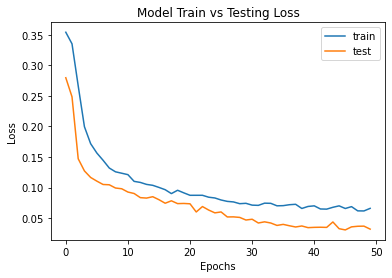

Test RMSE: 84.150
Test MAE: 63.403


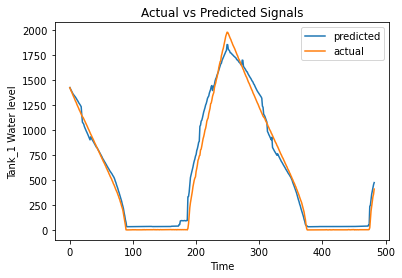

In [2]:
from math import sqrt
from numpy import array
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# convert series to supervised learning
def series_to_supervised2(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
#dataset = read_csv('phy_cps.csv', header=0, index_col=0)
dataset = read_csv('phy_att_test_processed.csv', header=0, index_col=0)
values = dataset.to_numpy()
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised2(scaled, 1, 1)

# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,1,2,3,4,5]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]], axis=1, inplace=True)
reframed.drop(reframed.columns[[41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
#n_train_hours = 365 * 24
#n_train_hours = 484
n_train_hours = 1936
# Not 1936
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
#model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(20, activation='relu',return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(10, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(5, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')
model.compile(loss='mae', optimizer='adam')
# fit network
#history = model.fit(train_X, train_y, epochs=70, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.title('Model Train vs Testing Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

'''
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(test_y, label='actual')
pyplot.legend()
pyplot.show()
'''

# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
mae = mean_absolute_error(inv_y, inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

# # Save the model to disk
# model.save('lstm_model.h5')
# print('Model saved to disk')

pyplot.xlabel('Time')
pyplot.ylabel('Tank_1 Water level')
pyplot.title('Actual vs Predicted Signals')
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(inv_y, label='actual')
pyplot.legend()
# pyplot.legend(['train','test'], loc='upper left')
pyplot.show()


In [3]:
# import pandas as pd
# import matplotlib.pyplot as plt
# conf = pd.read_csv("confidence.csv", header=0)
# fig = plt.figure(figsize=(8, 5))
# # Creating azes instances
# ax = fig.add_axes([0,0,1,1])
# # Creating plot
# bp = ax.boxplot(conf)
# plt.show()

### Optimisation in Python

In [4]:
import numpy as np
from scipy.optimize import minimize

In [5]:
def objective(x):
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    x4 = x[3]
    return x1*x4*(x1+x2+x3)+x3
def constraint1(x):
    return x[0]*x[1]*x[2]*x[3]-25.0
def constraint2(x):
    sum_sq = 40
    for i in range(4):
        sum_sq = sum_sq - x[i]**2
    return sum_sq


In [6]:
x0 = [1,5,5,1]
print(objective(x0))

16


In [7]:
b = (1.0,5.0)
bnds = (b,b,b,b)
con1 = {'type':'ineq','fun': constraint1}
con2 = {'type':'eq','fun': constraint2}
cons = [con1,con2]

In [8]:
sol = minimize(objective,x0,method='SLSQP', bounds=bnds,constraints=cons)

In [9]:
print(sol)

     fun: 17.01401724563517
     jac: array([14.57227015,  1.37940764,  2.37940764,  9.56415057])
 message: 'Optimization terminated successfully'
    nfev: 25
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([1.        , 4.7429961 , 3.82115462, 1.37940765])


In [10]:
print(sol.x)

[1.         4.7429961  3.82115462 1.37940765]


### Iterate the training

In [ ]:
import random
from csv import writer

random.seed(10)
dataset = read_csv('phy_att_test_processed.csv', header=0, index_col=0)
values = dataset.to_numpy()
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised2(scaled, 1, 1)

# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,1,2,3,4,5]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]], axis=1, inplace=True)
reframed.drop(reframed.columns[[41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79]], axis=1, inplace=True)
#print(reframed.head())
 
# split into train and test sets
values = reframed.values
#n_train_hours = 365 * 24
#n_train_hours = 484
n_train_hours = 1936
# Not 1936
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

rmse_list = []
 # design network
model = Sequential()
#model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(20, activation='relu',return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(10, activation='relu', return_sequences=True))
model.add(LSTM(5, activation='relu'))
model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')
model.compile(loss='mae', optimizer='adam')
# fit network
#history = model.fit(train_X, train_y, epochs=70, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(test_X, test_y), verbose=0, shuffle=False)

for i in range(3):
   
   
    # make a prediction
    yhat = model.predict(test_X)
    test2_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test2_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test2_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test2_y, test2_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    rmse_list.append(rmse)
    
    with open('iteration_result.csv', 'a', newline='') as f_object:
        writer_object = writer(f_object)
        writer_object.writerow(rmse_list)
        f_object.close()


## Load the saved model

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.892424   0.548454   0.653787   0.020599   0.000000   0.156182   
2   0.908081   0.543299   0.656878   0.017790   0.000000   0.156182   
3   0.918182   0.535052   0.665379   0.018727   0.001214   0.138829   
4   0.934343   0.529897   0.667697   0.019663   0.001214   0.121475   
5   0.953030   0.522165   0.677743   0.019663   0.001214   0.121475   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var32(t-1)  var33(t-1)  \
1        1.0   0.586957        0.0         1.0  ...         0.0         0.0   
2        1.0   0.586957        0.0         1.0  ...         0.0         0.0   
3        1.0   0.602767        0.0         1.0  ...         0.0         0.0   
4        1.0   0.618577        0.0         1.0  ...         0.0         0.0   
5        1.0   0.634387        0.0         1.0  ...         0.0         0.0   

   var34(t-1)  var35(t-1)  var36(t-1)  var37(t-1)  var38(t-1)  var39(t-1)  \
1         0.0        

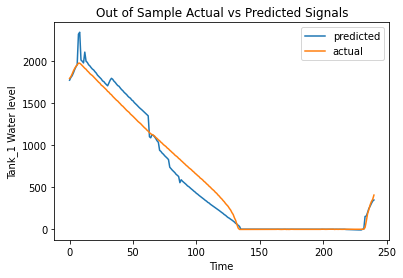

In [38]:
from pandas import read_csv
from keras.models import load_model

model = load_model('lstm_model.h5')

out_dataset = read_csv('phy_cps_out-of-sample.csv', header=0, index_col=0)
t_values = out_dataset.to_numpy()

t_values = out_dataset.values

t_values = t_values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(t_values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]], axis=1, inplace=True)
reframed.drop(reframed.columns[[41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
t_values = reframed.values

test = t_values
# split into input and outputs
#train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# plot history
'''
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
'''
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

model.summary()

pyplot.xlabel('Time')
pyplot.ylabel('Tank_1 Water level')
pyplot.title('Out of Sample Actual vs Predicted Signals')
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(inv_y, label='actual')
pyplot.legend()
pyplot.show()

### Out of sample testing

   var1(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  \
1   0.892424  0.908081  0.543299  0.656878  0.017790  0.000000  0.156182   
2   0.908081  0.918182  0.535052  0.665379  0.018727  0.001214  0.138829   
3   0.918182  0.934343  0.529897  0.667697  0.019663  0.001214  0.121475   
4   0.934343  0.953030  0.522165  0.677743  0.019663  0.001214  0.121475   
5   0.953030  0.967677  0.515464  0.680835  0.016854  0.001214  0.086768   

   var7(t)   var8(t)  var9(t)  ...  var31(t)  var32(t)  var33(t)  var34(t)  \
1      1.0  0.586957      0.0  ...       0.0       0.0       0.0       0.0   
2      1.0  0.602767      0.0  ...       0.0       0.0       0.0       0.0   
3      1.0  0.618577      0.0  ...       0.0       0.0       0.0       0.0   
4      1.0  0.634387      0.0  ...       0.0       0.0       0.0       0.0   
5      1.0  0.650198      0.0  ...       0.0       0.0       0.0       0.0   

   var35(t)  var36(t)  var37(t)  var38(t)  var39(t)  var40(t)  
1       1.

Epoch 84/100
61/61 - 0s - loss: 0.0086 - val_loss: 0.0512 - 249ms/epoch - 4ms/step
Epoch 85/100
61/61 - 0s - loss: 0.0095 - val_loss: 0.0577 - 219ms/epoch - 4ms/step
Epoch 86/100
61/61 - 0s - loss: 0.0085 - val_loss: 0.0393 - 246ms/epoch - 4ms/step
Epoch 87/100
61/61 - 0s - loss: 0.0101 - val_loss: 0.0336 - 284ms/epoch - 5ms/step
Epoch 88/100
61/61 - 0s - loss: 0.0091 - val_loss: 0.0422 - 253ms/epoch - 4ms/step
Epoch 89/100
61/61 - 0s - loss: 0.0089 - val_loss: 0.0512 - 187ms/epoch - 3ms/step
Epoch 90/100
61/61 - 0s - loss: 0.0078 - val_loss: 0.0449 - 183ms/epoch - 3ms/step
Epoch 91/100
61/61 - 0s - loss: 0.0076 - val_loss: 0.0368 - 168ms/epoch - 3ms/step
Epoch 92/100
61/61 - 0s - loss: 0.0076 - val_loss: 0.0393 - 183ms/epoch - 3ms/step
Epoch 93/100
61/61 - 0s - loss: 0.0073 - val_loss: 0.0460 - 186ms/epoch - 3ms/step
Epoch 94/100
61/61 - 0s - loss: 0.0071 - val_loss: 0.0454 - 180ms/epoch - 3ms/step
Epoch 95/100
61/61 - 0s - loss: 0.0069 - val_loss: 0.0395 - 183ms/epoch - 3ms/step
Epoc

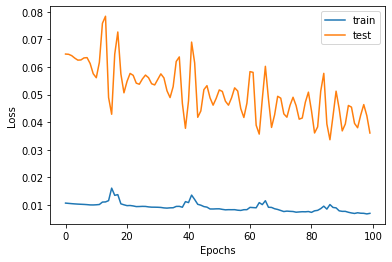

Test RMSE: 1592.419


In [13]:
#dataset = out_dataset
out_dataset = read_csv("phy_cps_out-of-sample.csv", header=0, index_col=0)
t_values = out_dataset.to_numpy()

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
#dataset = read_csv('phy_cps.csv', header=0, index_col=0)
t_values = out_dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
t_values = t_values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(t_values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.drop(reframed.columns[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
t_values = reframed.values

test = t_values
# split into input and outputs
#train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# # design network
# model = Sequential()
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam')

# fit network
#history = model.fit(train_X, train_y, epochs=70, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

### Global surrogate model: Easy to implement (From YouTube: Global Surrogate Model for Interpretable AI)

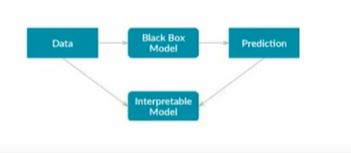

In [10]:
from IPython.display import Image
Image(filename='global_surrogate.jpg') 

In [11]:
import pandas as pd
df = pd.read_csv("testData.csv")
n = 540

data = df.to_numpy()

# ensure all data is float
data = data.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)

train = scaled[:n,:]
test = scaled[n:,:]

X_train, y_train = train[:,:-1], train[:,-1]
X_test, y_test = test[:,:-1], test[:,-1]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)



(540, 9) (540,) (228, 9) (228,)


ValueError: x and y must be the same size

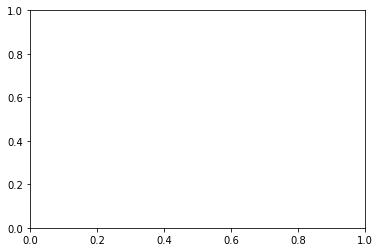

In [14]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Create blackbox model
blackbox_model = RandomForestRegressor(n_estimators=500, max_depth=6, min_samples_leaf=100)
#blackbox_model.fit(X_train.reshape(-1,1) ,y_train.reshape(-1,1))
blackbox_model.fit(X_train ,y_train)
#result = blackbox_model.predict(X_test.reshape(-1,1))
result = blackbox_model.predict(X_test)

# Visualize the random forest regression result
#X_grid = np.arange(min(X_train), max(X_train), 0.01)
#X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X_train, y_train, color='red')
plt.plot(X_grid, regressor.predict(X_grid), color='blue')
plt.title('Truth or Bluff (Random Forest Regression)')
plt.xlabel('Position level')
plt.ylabel('y_label')
plt.show()


# Create surrogate model
new_target = blackbox_model.predict(X_train)
surrogate_model = DecisionTreeRegressor(max_depth=6)
surrogate_model.fit(X_train,new_target)

# Get feature importances
feature_importance = pd.DataFrame()
# feature_importance['feature'] = X_train.columns
#feature_importance['X1'] = X_train.X1
#feature_importance['importance'] = surrogate_model.feature_importances_

# Get feature importance values
#feature_importance.sort_values(by='importance', ascending=False).head(20)

In [11]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
data = pd.read_csv('pollution.csv')
data.info()
data.drop(['date','wnd_dir'], axis=1, inplace=True)
scaler = MinMaxScaler()
scaler.fit(data)
scaled = scaler.fit_transform(data)
x = pd.DataFrame(scaled, columns=data.columns)
x

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  float64
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.0+ MB


,pollution,dew,temp,press,wnd_spd,snow,rain
0,0.129779,0.352941,0.245902,0.527273,0.002290,0.000000,0.0
1,0.148893,0.367647,0.245902,0.527273,0.003811,0.000000,0.0
2,0.159960,0.426471,0.229508,0.545455,0.005332,0.000000,0.0
3,0.182093,0.485294,0.229508,0.563636,0.008391,0.037037,0.0
4,0.138833,0.485294,0.229508,0.563636,0.009912,0.074074,0.0
...,...,...,...,...,...,...,...
43795,0.008048,0.250000,0.278689,0.781818,0.395659,0.000000,0.0
43796,0.010060,0.264706,0.262295,0.781818,0.405588,0.000000,0.0
43797,0.010060,0.264706,0.262295,0.781818,0.413996,0.000000,0.0
43798,0.008048,0.264706,0.245902,0.781818,0.420866,0.000000,0.0
